In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.all import (
    ModelVisualizer,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    ConstantValueSource,
    ConstantVectorSource,
    AbstractValue,
    RigidTransform,
    RotationMatrix
)

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
import matplotlib.pyplot as plt
import numpy as np

import sponana.utils
from sponana.perception import (
    BananaSpotter,
    add_camera_pose_extractor,
    add_body_pose_extractor,
)
from sponana.controller import SpotController, solve_ik
from sponana.debug_logger import DebugLogger
from sponana.planner import Navigator
from sponana.grasping.grasp_system import Grasper

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [4]:
# BODY_NAME = "banana" 
BODY_NAME = "base_link_sugar"

In [5]:
def create_scene(banana_pose, desired_base_position, scenario_data: str, debug: bool = True):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        sponana.utils.MakeSponanaHardwareStation(
            scenario, meshcat
        )
    )
    ts = station.GetSubsystemByName("plant").time_step()
    print(f"Time step: { ts } ")

    spot_plant = station.GetSubsystemByName(
        "spot.controller"
    ).get_multibody_plant_for_control()
    spot_controller = builder.AddSystem(
        SpotController(spot_plant, meshcat=meshcat, use_teleop=False)
    )
    builder.Connect(
        spot_controller.get_output_port(),
        station.GetInputPort("spot.desired_state"),
    )

    # Grasper
    grasper = builder.AddNamedSystem("grasper", Grasper(meshcat=meshcat))
    builder.Connect(
        grasper.GetOutputPort("arm_position"),
        spot_controller.GetInputPort("desired_arm_position")
    )
    builder.Connect(
        station.GetOutputPort("spot.state_estimated"),
        grasper.GetInputPort("spot_state")
    )
    banana_pose_source = builder.AddNamedSystem("banana_pose_source", ConstantValueSource(AbstractValue.Make(banana_pose)))
    builder.Connect(
        banana_pose_source.get_output_port(),
        grasper.GetInputPort("banana_pose")
    )
    time_zero_source = builder.AddNamedSystem("time_zero_source", ConstantVectorSource(np.array([1.0])))
    builder.Connect(
        time_zero_source.get_output_port(),
        grasper.GetInputPort("reset_time")
    )

    base_position_source = builder.AddNamedSystem("base_position_source", ConstantVectorSource(desired_base_position))
    builder.Connect(
        base_position_source.get_output_port(),
        spot_controller.GetInputPort("desired_base_position"),
    )

    # Get camera poses
    spot_camera_config = scenario.cameras["spot_camera"]
    camera_pose_extractor = add_camera_pose_extractor(
        spot_camera_config, station, builder
    )

    # Camera to Perception
    spot_camera = station.GetSubsystemByName("rgbd_sensor_spot_camera")
    banana_spotter = builder.AddSystem(BananaSpotter(spot_camera))
    banana_spotter.set_name("banana_spotter")
    builder.Connect(
        station.GetOutputPort("spot_camera.rgb_image"),
        banana_spotter.get_color_image_input_port(),
    )
    builder.Connect(
        station.GetOutputPort("spot_camera.depth_image"),
        banana_spotter.get_depth_image_input_port(),
    )

    # Banana pose (for debugging)
    banana_pose_extractor = add_body_pose_extractor(
        "banana", BODY_NAME, station, builder
    )
    # builder.Connect(
    #     banana_pose_extractor.get_output_port(),
    #     spot_controller.GetInputPort("desired_gripper_pose"),
    # )

    if debug:
        # Connect debugger
        debugger = builder.AddNamedSystem(
            "debug_logger", DebugLogger(spot_camera, meshcat)
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.rgb_image"),
            debugger.get_color_image_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.depth_image"),
            debugger.get_depth_image_input_port(),
        )
        builder.Connect(
            camera_pose_extractor.get_output_port(),
            debugger.get_camera_pose_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot.state_estimated"),
            debugger.get_spot_state_input_port(),
        )
        builder.Connect(
            banana_pose_extractor.get_output_port(),
            debugger.get_banana_pose_input_port(),
        )

    diagram = builder.Build()
    diagram.set_name("everything")  # the outmost diagram
    return diagram

In [6]:
# - add_model:
#     name: banana
#     file: package://sponana/banana/banana.sdf
#     default_free_body_pose:
#         banana:
#             # move it in front of Spot 
#             translation: [1.45, 0, 0.45]

# - add_model:
#     name: banana
#     file: package://manipulation/hydro/004_sugar_box.sdf
#     default_free_body_pose:
#         base_link_sugar:
#             # move it in front of Spot 
#             translation: [1.45, 0, 0.45]

scenario_data = """
cameras:
    spot_camera:
        name: spot_camera
        depth: True
        X_PB:
            translation: [0, 0.05, 0]
            base_frame: spot_camera::base
            rotation: !Rpy { deg: [-90, 0, 0] }

directives:
- add_model:
    name: spot
    file: package://sponana/grasping/spot.urdf
    default_joint_positions:
        # fold the arm
        arm_sh1: [-3.1]
        arm_el0: [3.1]
    
- add_model:
    name: banana
    file: package://sponana/grasping/004_sugar_box.sdf
    default_free_body_pose:
        base_link_sugar:
            # move it in front of Spot 
            translation: [1.45, 0, 0.45]
            rotation: !Rpy { deg: [0, 90, 0] }

- add_model:
    name: floor
    file: package://sponana/platform.sdf

- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: spot_camera
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: spot_camera::base
    X_PC:
        translation: [0.4, 0, 0]
        rotation: !Rpy { deg: [-30, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""

In [9]:
banana_pose = RigidTransform(
  R=RotationMatrix([
    [0.9999107308839879, 0.009389862951888045, 0.009505826465590237],
    [-0.008962400073846544, 0.9989889507438625, -0.0440539632336637],
    [-0.009909876284064848, 0.04396483555549183, 0.9989839275917372],
  ]), 
  p=[1.4498836082822446, -0.0005091282959336326, 0.011183177445165213],
)
desired_base_position = np.array([ 0.8,  1.01800645e-05, -1.21911880e-01])
diagram = create_scene(banana_pose, desired_base_position, scenario_data)
simulator = Simulator(diagram)
sponana.utils.run_simulation(simulator, meshcat, finish_time=10)

Time step: 0.001 
Press Space to log system info
Re-initializing
sampling grasps...


pointcloud transform: RigidTransform(
  R=RotationMatrix([
    [0.9999107308839879, 0.009389862951888045, 0.009505826465590237],
    [-0.008962400073846544, 0.9989889507438625, -0.0440539632336637],
    [-0.009909876284064848, 0.04396483555549183, 0.9989839275917372],
  ]),
  p=[1.4498836082822446, -0.0005091282959336326, 0.011183177445165213],
)
-0.25102622651604634
{'initial': RigidTransform(
  R=RotationMatrix([
    [-0.12099248554456161, 0.9926534230926538, 8.011632546188707e-06],
    [-0.9926534231208596, -0.12099248556338493, 1.9062678247570728e-06],
    [2.861610616759852e-06, -7.72213038952484e-06, 0.9999999999660901],
  ]),
  p=[1.0761653308737622, -0.033797988391447584, 0.797076719867911],
), 'post_init': RigidTransform(
  R=RotationMatrix([
    [-0.12099248554456161, 0.9926534230926538, 8.011632546188707e-06],
    [-0.9926534231208596, -0.12099248556338493, 1.9062678247570728e-06],
    [2.861610616759852e-06, -7.72213038952484e-06, 0.9999999999660901],
  ]),
  p=[1.175432275

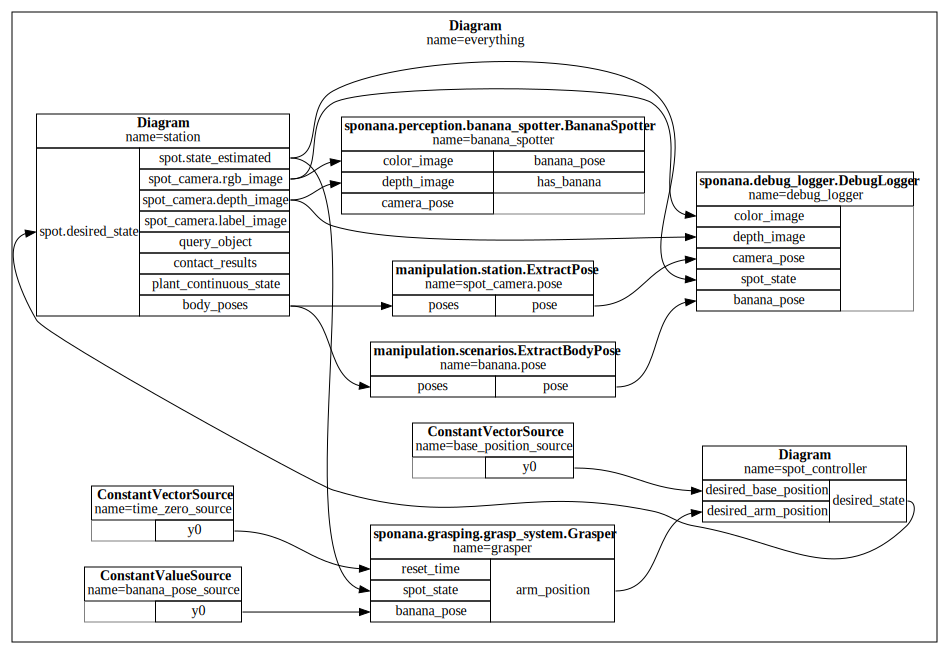

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)